In [1]:
from Helper.ml_models import *
from Helper.Helper_functions import * 
from torchvision.models.segmentation import *
import gc, sys
import cv2 as cv
from torchvision.utils import draw_segmentation_masks
from tqdm import tqdm


In [2]:
city_label_color_map = np.array([
    [255, 255, 0], #ID__0, road
    [244, 35, 232],  #ID__1, sidewalk
    [70, 70, 70],    #ID__2, building
    [102, 102, 156], #ID__3, wall
    [190, 153, 153], #ID__4, fence
    [153, 153, 153], #ID__5, pole
    [250, 170, 30],  #ID__6, traffic light
    [220, 220, 0],   #ID__7, traffic sign
    [107, 142, 35],  #ID__8, vegetation
    [152, 251, 152], #ID__9, terrain
    [70, 130, 180],  #ID__10, sky
    [220, 20, 60],   #ID__11, person
    [255, 0, 0],     #ID__12, rider
    [0, 0, 142],     #ID__13, car
    [0, 0, 70],      #ID__14, truck
    [0, 60, 100],    #ID__15, bus
    [0, 80, 100],    #ID__16, train
    [0, 0, 230],     #ID__17, motorcycle
    [119, 11, 32],   #ID__18, bicycle
    [0, 0, 0],       #ID__19, unlabeled
])

In [3]:
duplicates = check_duplicates_in_csv('Daten/CityscapesDaten')
print(f'List of duplicates \n {duplicates} \n')

List of duplicates 
 set() 



In [4]:
k_fold_dataset = K_Fold_Dataset(image_dir='CityscapesDaten/images',
                                            annotation_dir='CityscapesDaten/semantic',
                                            k_fold_csv_dir='Daten/CityscapesDaten',
                                            leave_out_fold=0)
k_fold_dataset.check_for_data_leaks()  

No data leaks found.


In [5]:
image, annotation = k_fold_dataset.train_dataset[0]

print(f'Image shape: {image.shape}, Annotation shape: {annotation.shape}')
print(f'Annotation Value range: {np.unique(annotation)}')

Image shape: torch.Size([3, 520, 520]), Annotation shape: torch.Size([520, 520])
Annotation Value range: [  0   1   2   5   7   8   9  10  13 255]


In [6]:
unique_values = set()
for _, annotation in tqdm(k_fold_dataset.train_dataset, desc='Processing Annotations'):
    unique_values.update(np.unique(annotation))
    if len(unique_values) >= 2:
        break

print(f'Unique values in annotations: {unique_values}')
print(f'Number of unique values in annotations: {len(unique_values)}')


Processing Annotations:   0%|          | 0/2224 [00:00<?, ?it/s]

Unique values in annotations: {0, 1, 2, 5, 7, 8, 9, 10, 13, 255}
Number of unique values in annotations: 10


Using CUDA GPU
Model loaded: deeplabv3_resnet50 | Device: cuda 
Inference result shape: torch.Size([1, 20, 520, 520])


TypeError: Invalid shape (520,) for image data

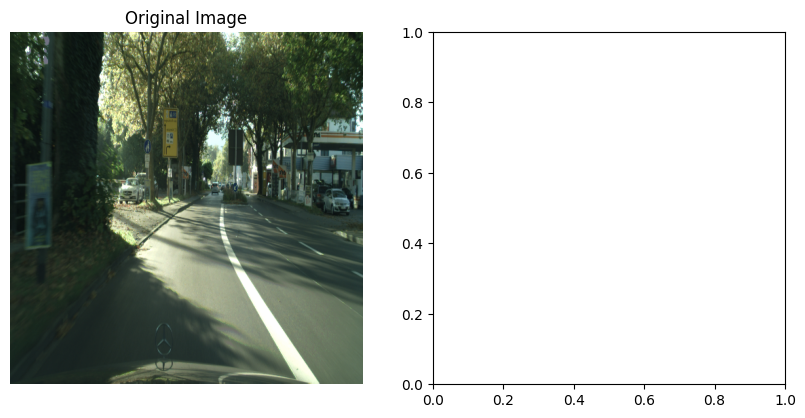

In [7]:
mean = torch.tensor((0.2892, 0.3272, 0.2867)).view(3, 1, 1)
std = torch.tensor((0.1904, 0.1932, 0.1905)).view(3, 1, 1)
image_unnormalized = image * std + mean

# Convert the image to uint8
image_uint8 = (image_unnormalized * 255).byte()
annotation_bool = annotation.bool()
colors = [city_label_color_map[i] for i in range(20)] 

result_image = draw_segmentation_masks(image_uint8,
                                       annotation_bool,
                                       0.3, 
                                       colors
                                       )
result_image_np = result_image.numpy().transpose(1, 2, 0)

model = TrainedModel('deeplabv3_resnet50', 2048, 1024, 'deeplabv3_resnet50_k_fold_0', start_epoch='latest')
output = model.inference(image)
print(f'Inference result shape: {output.shape}')
all_masks = output.argmax(1) == torch.arange(20, device=torch.device('cuda'))[:, None, None]
inf_result_image = draw_segmentation_masks(image_uint8,
                                           all_masks,
                                           0.3,
                                           colors)

# fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# # Display the first image
# axs[0].imshow(result_image_np)
# axs[0].axis('off')

# # Display the second image
# inf_result_image_np = inf_result_image.numpy().transpose(1, 2, 0)
# axs[1].imshow(inf_result_image_np)
# axs[1].axis('off')

# plt.tight_layout()
# plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
axs[0].imshow(image_uint8.permute(1, 2, 0))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Display the annotation
axs[1].imshow(annotation[0], cmap='gray')
axs[1].set_title('Annotation')
axs[1].axis('off')

plt.tight_layout()
plt.show()